## Set-up
* importing necessary packages and defining parameters

In [205]:
import numpy as np
import cv2
import math 
from shapely.geometry import Polygon
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from matplotlib import colors
from scipy.signal import argrelextrema
import pandas as pd
import csv
import os
from scipy.ndimage import gaussian_filter1d
import re


In [207]:
extension_factor = 1.1
step_size = 2
max_width = 2048
overlap_thresh = 0.3
weight_epithelium_coverage = 0.8
weight_background_pixels = 0.2
sigma_factor = 20

## *** IMPORTANT *** 
This code relies on the slice images and masks being in a folder called `testing_slices/`

Inside that folder, create a folder called `patch_outputs/` for the patches to be exported into

In [210]:
image_folder = './testing_slices'
#image_files = [f for f in os.listdir(image_folder) if f.startswith('h&e')]

In [212]:
weights_df = pd.read_csv("weights_df.csv")

## Updated patching code

In [215]:
def estimate_curvature_complexity(points):
    """
    Estimate complexity of a contour based on curvature variations.
    """

    if len(points)<5:
        return 1
    
    diffs=np.gradient(points, axis=0)
    curvature=np.linalg.norm(np.gradient(diffs,axis=0),axis=1)

    # Count number of local maxima in curvature (sharp points)
    peaks=argrelextrema(curvature, np.greater)[0]
    
    #Return peaks/points for rough approx of sharp changes
    return len(peaks)/len(points)

In [217]:
def find_external_contours(binary_image):
    '''find all ext`ernal contours of an image'''

    contours,hierarchy=cv2.findContours(binary_image,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    #This can be used to alter the order contour points are processed in while maintaining order
        #Think [1,2,3,4,5]->[4,5,1,2,3]
        #Set to 0 for no effect, check np documentation for more info
    return [np.roll(contour,0,axis=0) for contour in contours if len(contour)>1]


def gaussian_normals(contours):
    #Initialize list for final normals
    all_normals=[]
    smooth=[]

    #Loop through all contours
    for contour in contours:
        #Reshape contour into point pairings
        points=contour.reshape(-1,2).astype(np.float32)
        
        #Define sigma paramter(std for Gaussian Kernel from contour length)
        #Higher value of sigma means more aggressive smoothing
        #sigma,smoothed=estimate_sigma(points,1,1e-5,60)
        sigma=max(len(contour)*estimate_curvature_complexity(points)//sigma_factor,1)
        smoothed=gaussian_filter1d(points,sigma,axis=0, truncate = 100)
        print(f'Sigma of : {sigma}')
        #Apply Gaussian smoothing to X and Y values, attempting to remove noise from the contour
        #smoothed=np.apply_along_axis(lambda x: gaussian_filter1d(x,sigma,mode='reflect'),axis=0,arr=points)
        #Calculate gradients of X and Y for use then finding the tangent
        gradients=np.gradient(smoothed,axis=0)
        #Find vector norms of tangent vectors
        all_norms=np.linalg.norm(gradients,axis=1,keepdims=True)
        #Divide tangents by norms with numerical stability
        tangent_unit=gradients/(all_norms+1e-8)
        #Initialize normals
        normals=np.zeros_like(tangent_unit)
        
        normals = np.column_stack((-tangent_unit[:, 1], tangent_unit[:, 0]))
        all_normals.append(normals)
        smooth.append(smoothed.reshape(-1,1,2).astype(np.int32))

    return all_normals,smooth


def calculate_patch_corners(point, normal, binary_image, extension_factor=1.0, step_size=4, max_length=2048):
    """
    Calculate the corners of a square patch using epithelium width along the normal.

    Args:
        point (np.ndarray): The point on the contour.
        normal (np.ndarray): The normal vector at the point.
        binary_image (np.ndarray): Binary mask of the tissue.
        extension_factor (float): Factor to slightly enlarge the patch (e.g., 1.1 for 10% increase).
        step_size (int): Step size for checking tissue boundaries along the normal.
        max_length (int): Maximum distance to search for epithelium width.

    Returns:
        np.ndarray: The four corners of the square patch.
        int: The computed patch height.
    """
    height, width = binary_image.shape
    point = point.astype(int)

    # generating forward and backward points along the normal
    steps = np.arange(0, max_length, step_size)[:, None]
    points = np.clip(point - steps * normal, 0, [width - 1, height - 1]).astype(int)

    # extracting pixel values along the normal path
    values = binary_image[points[:, 1], points[:, 0]]

    # finding the first background pixel (where value == 0)
    stop = np.where(values == 0)[0]

    # computing distances
    width = stop[0] * step_size if stop.size > 0 else max_length

    # computing total epithelium width and adjust for stroma extension
    extended_length = int(width * extension_factor)
    half_size = extended_length // 2 

    # computing tangent vector (perpendicular to normal)
    tangent = np.array([-normal[1], normal[0]])

    # defining square corners (same logic as `calculate_square_corners`)
    corners = np.array([
        point + (tangent * half_size),
        point - (tangent * half_size),
        point - (tangent * half_size) - (normal * extended_length),
        point + (tangent * half_size) - (normal * extended_length)
    ])

    return corners, extended_length

In [219]:
def calculate_square_overlap(square1,square2):
    '''Calculate overlap ratio between squares'''

    square1=Polygon(square1)
    square2=Polygon(square2)

    if not square1.intersects(square2):
        return 0
    
    intersection_area=square1.intersection(square2).area
    smallest_area=min(square1.area,square2.area)
    return intersection_area/(smallest_area+1e-8)

def numpy_polygon_area(contour):
    """
    Compute polygon area using the shoelace formula.
    contour: array-like of shape (N, 2) or (N, 1, 2)
    """
    contour = np.asarray(contour, dtype=np.float32)

    if contour.ndim == 3 and contour.shape[2] == 2:
        contour = contour.reshape(-1, 2)
    elif contour.ndim == 2 and contour.shape[1] == 2:
        pass
    else:
        raise ValueError(f"Unexpected contour shape for area: {contour.shape}")

    x = contour[:, 0]
    y = contour[:, 1]
    # shoelace formula
    return 0.5 * np.abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))


def create_smarter_squares(contours, normals, binary_image, overlap_thresh):
    """Create squares that meet overlap thresh with last square"""
    return_squares = []
    return_patch_length = []
    
    # Loop over all contours and get corresponding normals to point
    for idx, (contour, contour_normals) in enumerate(zip(contours, normals)):
        # ---------- DEBUG: see what we actually got ----------
        print(f"\n[DEBUG] Contour idx {idx}: raw type = {type(contour)}")
        try:
            contour_np = np.asarray(contour)
            print(f"[DEBUG] contour_np type = {type(contour_np)}, shape = {contour_np.shape}, dtype = {contour_np.dtype}")
        except Exception as e:
            print(f"[DEBUG] Failed to convert contour to np.array: {e}")
            continue
        # ------------------------------------------------------

        if contour_np.size == 0:
            print("[DEBUG] Skipping empty contour")
            continue

        # Normalize shape to something OpenCV likes
        if contour_np.ndim == 3 and contour_np.shape[2] == 2:
            contour_for_area = contour_np.reshape(-1, 2)
        elif contour_np.ndim == 2 and contour_np.shape[1] == 2:
            contour_for_area = contour_np
        else:
            print("[DEBUG] Skipping contour with unexpected shape:", contour_np.shape)
            continue

        # One more debug check just before calling contourArea
        print(f"[DEBUG] contour_for_area type = {type(contour_for_area)}, "
              f"shape = {contour_for_area.shape}, dtype = {contour_for_area.dtype}")

        points = contour_for_area.reshape(-1, 2)
        squares = []
        patch_length = []
        last_square = None

        # Go over points, evaluating if next square's corner falls outside of range of last square
        for i, point in enumerate(points):
            corners, length = calculate_patch_corners(point, contour_normals[i], binary_image)

            overlap_thresh_size_fn = min(
                0.8,
                overlap_thresh + max((length - 100) * 1.5 * overlap_thresh / 900, 0)
            )

            # Prevent poorly sized squares
            # Finding rough area approximation in terms of patch length
            try:
                # OpenCV usually wants float32 or int32
                area = cv2.contourArea(contour_for_area.astype(np.float32))
            except Exception as e:
                print(f"[DEBUG] contourArea failed on contour idx {idx}: {e}")
                break  # bail out of this contour entirely

            area = numpy_polygon_area(contour_for_area)
            side_length = np.sqrt(area)
            # Approximately: want squares less than 50% of contour area, and minimum of 2% area
            if length < side_length * 0.02:
                continue

            # Check to see if first square and check against last square to prevent long loop
            elif last_square is not None and calculate_square_overlap(last_square, corners) > overlap_thresh_size_fn:
                if Polygon(last_square).area > Polygon(corners).area and calculate_square_overlap(last_square, corners) > 0.98:
                    squares[-1] = corners
                    last_square = corners
                    continue
                continue

            # Check against all squares to prevent big patches covering thin sections next to large ones
            elif any(calculate_square_overlap(corners, square) > overlap_thresh_size_fn for square in squares):
                continue

            squares.append(corners)
            patch_length.append(length)
            last_square = corners

        return_squares.append(squares)
        return_patch_length.append(patch_length)

    return return_squares, return_patch_length


In [221]:
def draw_squares(
    image,
    squares_list,
    effective_weights=None,   # optional list/array of weights
    default_color=(255, 0, 0),
    border_thickness=2
):
    """
    Draw squares on image.

    If `effective_weights` is provided, each patch is filled with a grayscale
    color derived from its weight (higher weight = darker).

    DEBUG prints:
      - whether weights are used
      - how many weights we got
      - min/max of the weights
    """

    result = image.copy()

    # If no weights provided, fall back to the old behavior
    if effective_weights is None:
        print("[draw_squares] effective_weights is None → drawing ONLY red outlines.")
        for squares in squares_list:
            for square in squares:
                points = square.astype(np.int32)
                cv2.polylines(
                    result,
                    [points],
                    isClosed=True,
                    color=default_color,
                    thickness=border_thickness
                )
        return result

    # ---- Weighted coloring path ----
    weights = np.asarray(effective_weights, dtype=float)

    if weights.size == 0:
        print("[draw_squares] effective_weights is an empty array → drawing ONLY red outlines.")
        for squares in squares_list:
            for square in squares:
                points = square.astype(np.int32)
                cv2.polylines(
                    result,
                    [points],
                    isClosed=True,
                    color=default_color,
                    thickness=border_thickness
                )
        return result

    w_min = float(weights.min())
    w_max = float(weights.max())
    denom = (w_max - w_min) if (w_max > w_min) else 1.0

    print(f"[draw_squares] Using {len(weights)} weights. min={w_min:.3g}, max={w_max:.3g}")

    patch_idx = 0

    for squares in squares_list:
        for square in squares:
            points = square.astype(np.int32)

            if patch_idx < len(weights):
                w = weights[patch_idx]
            
                eps = 1e-8
                log_w = math.log10(w + eps)
                log_weights = np.log10(weights + eps)
                log_min = np.percentile(log_weights, 5)
                log_max = np.percentile(log_weights, 95)
            
                if log_max == log_min:
                    norm = 0.0
                else:
                    norm = (log_w - log_min) / (log_max - log_min)
            
                norm = max(0.0, min(1.0, norm))
            
                red   = int(50 + 205 * norm)  # 50 → 255
                green = 0
                blue  = 0
            
                fill_color = (blue, green, red)   # BGR
            
                cv2.fillPoly(result, [points], color=fill_color)
                cv2.polylines(
                    result,
                    [points],
                    isClosed=True,
                    color=(0, 0, 0),
                    thickness=border_thickness
                )
            else:
                # Safety fallback: draw outline if we ran out of weights
                print("[draw_squares] WARNING: more patches than weights → extra patches in red.")
                cv2.polylines(
                    result,
                    [points],
                    isClosed=True,
                    color=default_color,
                    thickness=border_thickness
                )

            patch_idx += 1

    return result


In [223]:
def draw_patches(image, patch_list, color = [255,0,0], thickness = 20):
    patches_on_slice = image.copy()
    for squares in patch_list:
        for square in squares:
            points=square.astype(np.int32)
            cv2.polylines(patches_on_slice,[points],isClosed=True,color=color,thickness=thickness)
    return patches_on_slice

In [225]:
# def draw_squares(image,squares_list,color=[255,0,0],thickness=20):
#     '''Draw squares on image'''

#     result=image.copy()

#     for squares in squares_list:
#         for square in squares:
#             points=square.astype(np.int32)
#             cv2.polylines(result,[points],isClosed=True,color=color,thickness=thickness)
        
#     return result

# # Function to draw patches
# def draw_patches(image, patch_list, color = [255,0,0], thickness = 20):
#     patches_on_slice = image.copy()
#     for squares in patch_list:
#         for square in squares:
#             points=square.astype(np.int32)
#             cv2.polylines(patches_on_slice,[points],isClosed=True,color=color,thickness=thickness)
#     return patches_on_slice



In [227]:
def process_contours(image, binary_image, overlap_thresh, effective_weights=None):
    contours = find_external_contours(binary_image)
    normals, smooth = gaussian_normals(contours)
    final_squares_list, patch_length_list = create_smarter_squares(
        contours, normals, binary_image, overlap_thresh
    )

    # Count how many patches we expect
    num_patches = sum(len(sq) for sq in final_squares_list)
    print(f"[process_contours] Found {len(contours)} contours, {num_patches} patches total.")

    if effective_weights is None:
        print("[process_contours] effective_weights is None (no weights passed in).")
    else:
        print(f"[process_contours] effective_weights length = {len(effective_weights)}")

    tissue_slice = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)

    # Draw squares (this will print its own debug info)
    result = draw_squares(
        tissue_slice,
        final_squares_list,
        effective_weights=effective_weights
    )

    return result, contours, final_squares_list, normals, patch_length_list


In [229]:
# def process_contours(image,binary_image,overlap_thresh):
#     """
#     Main function to process multiple contours and generate aligned squares along them.
    
#     Args:
#         image (np.ndarray): Original image
#         binary_image (np.ndarray): Binary mask of the shapes
#         overlap_thresh (float): Maximum allowed overlap between squares        
#     Returns:
#         tuple: (processed image, contours, squares_list)
#     """
#     contours=find_external_contours(binary_image)
#     if not contours:
#         return TypeError('No contours found')
    
#     #Condition check for square creation
#     #normals=calculate_contour_normals(contours,smoothing_size)
#     normals,smooth=gaussian_normals(contours)
#     #normals,smooth=fourier_normals(contours,0.999)
#     final_squares_list, patch_length_list = create_smarter_squares(contours,normals,binary_image,overlap_thresh=overlap_thresh)
#     tissue_slice = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    
#     result = draw_squares(tissue_slice,final_squares_list)
#     #Visualzie smoothed contour

#     try:
#         cv2.drawContours(result,smooth,-1,(0,255,0),30)
#     except:
#         print('No smoothed contour to show')
    
#     return result, contours, final_squares_list, normals, patch_length_list

In [231]:
# Carried over functions

def empty_folder():
    # delete everything out of directory
    output_folder = 'testing_slices/patch_outputs'
    if not os.path.exists(output_folder):  # Check if folder exists
        os.makedirs(output_folder)  # Create folder if it doesn't exist
    for file in os.listdir(output_folder):
        file_path = os.path.join(output_folder, file)
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            os.rmdir(file_path)

# Export patched slice into a new folder 
def export_patched_slice(patched_slice_name, selected_patches_on_slice):

    output_folder = os.path.join('testing_slices', 'patch_images')
    if not os.path.exists(output_folder):  # Check if folder exists
        os.makedirs(output_folder)  # Create folder if it doesn't exist

    output_path = os.path.join(output_folder, os.path.basename(patched_slice_name))
    cv2.imwrite(output_path, cv2.cvtColor(selected_patches_on_slice, cv2.COLOR_RGB2BGR))

# Calculate performance metrics
def calculate_metrics(epithelium_mask_2D, all_selected_patches):

    num_patches = len(np.vstack(all_selected_patches))

    total_epithelium_pixels = (epithelium_mask_2D > 0).sum()
    patch_mask = np.zeros_like(epithelium_mask_2D, dtype=np.uint8)

    #For all patches in all contours, use them to create a mask
    for contour_patches in all_selected_patches:
        for patch in contour_patches:
            patch = np.array(patch,dtype = np.int32).reshape(-1, 1, 2)
            cv2.fillPoly(patch_mask, [patch], 255)

    number_of_patch_mask_pixels = np.count_nonzero(patch_mask > 0)

    covered_epithelium_pixels = np.count_nonzero((patch_mask > 0) & (epithelium_mask_2D > 0))
    covered_background_pixels = np.count_nonzero((patch_mask > 0) & (epithelium_mask_2D == 0))

    total_epithelium_coverage = (covered_epithelium_pixels / total_epithelium_pixels*100)
    background_pixel_percent = (covered_background_pixels / number_of_patch_mask_pixels*100)
    score = weight_epithelium_coverage*total_epithelium_coverage + weight_background_pixels*(100 - background_pixel_percent)

    # Exporting performance metrics and parameter values
    metrics = pd.DataFrame({'Metric':['num_patches','total_epithelium_coverage', 'background_pixel_percent',
                        'score', 'extension_factor', 'step_size',
                        'max_width', 'overlap_threshold'], 
                'Value':[num_patches, total_epithelium_coverage, background_pixel_percent, score, 
                        extension_factor, step_size, max_width, overlap_thresh]})

    return metrics

def find_edges(all_selected_patches):
    all_points = np.vstack(all_selected_patches[0])

    edges = {'min_x': np.min(all_points[:, 0]),
             'max_x': np.max(all_points[:, 0]),
             'min_y': np.min(all_points[:, 1]),
             'max_y': np.max(all_points[:, 1])}

    return edges

def add_padding(image, edges):
        
    height, width, channels = image.shape

    if edges['min_x'] < 0:
        left = math.ceil(np.abs(edges['min_x']))
    else: left = 0

    if edges['max_x'] > width:
        right = math.ceil(edges['max_x'] - width)
    else: right = 0

    if edges['min_y'] < 0:
        top = math.ceil(np.abs(edges['min_y']))
    else: top = 0

    if edges['max_y'] > height:
        bottom = math.ceil(edges['max_y'] - height)
    else: bottom = 0

    new_width = width + right + left
    new_height = height + top + bottom
    

    # compute the padding color using the mode pixel value
    threshold = 150
    mask = np.all(image>threshold, axis = -1)
    if np.any(mask):
        bright_pixels = image[mask]
        if np.issubdtype(image.dtype,np.integer):
            dims = (np.iinfo(image.dtype).max + 1,) * channels
            combined = np.ravel_multi_index(bright_pixels.T,dims)
            unique_vals, counts = np.unique(combined, return_counts = True)
            mode_val = unique_vals[np.argmax(counts)]
            mode_color = np.array(np.unravel_index(mode_val, dims)).astype(image.dtype)
            pad_color = mode_color.flatten()
        else:
            pixels, counts = np.unique(bright_pixels, axis = 0, return_counts = True)
            pad_color = pixels[np.argmax(counts)]
    else:
        pad_color = np.array([threshold] * channels , dtype = image.dtype)


    padded_image = np.ones((new_height, new_width, channels), dtype=image.dtype) * pad_color

    # Insert the original image into the array of updated dimensions
    padded_image[top:top + height, left:left + width] = image


    return padded_image, right, left, top, bottom

# Shift patches by padding amount
def shift_patches(padded_image, all_selected_patches, left, top):

    all_points = np.vstack(all_selected_patches)

    shift_x = left
    shift_y = top
    shift_array = np.array([shift_x, shift_y])
    shifted_points = all_points + shift_array
    shifted_points = np.vstack(shifted_points)
    shifted_points = np.split(shifted_points, len(shifted_points) // 4)
    shifted_points = [shifted_points]   

    shifted_patches_on_slice = draw_patches(padded_image, shifted_points)

    return shifted_patches_on_slice, shifted_points

# edited to 
def show_shifted_patches(image, padded_image, all_selected_patches, shifted_patches_on_slice, binary_image):
    # Convert grayscale mask to RGB for overlaying patches
    mask_rgb = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)

    # Plot the original image and the patched mask side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    result = draw_patches(image,all_selected_patches)
    mask = draw_patches(mask_rgb,all_selected_patches)
    #mask = mask_rgb
    axes[0].imshow(result)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(mask)
    axes[1].set_title("Grayscale Mask with Patches")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()
    result = cv2.hconcat([result,mask])
    return result


def extract_square_images(image, points):
    
    patch_images = []
    square_list = np.vstack(points)

    for square in square_list:

        # create an empty mask with white inside just the square's region
        square = square.astype(np.int32)
        square.reshape((-1,1,2)) # bc cv2.fillpoly expects points to be in shape (N,1,2)
        mask = np.zeros(image.shape[:2],dtype = np.uint8)
        cv2.fillPoly(mask, [square], 255)

        # Apply the mask to the image
        masked_image = cv2.bitwise_and(image, image, mask = mask)

        # uncomment to see placement of patch within the entire slice image 
        # plt.imshow(masked_image)
        # plt.show()

        # Crop the image around the rotated square (will have black space due to rotation)
        x_min = np.min(square[:, 0])
        x_max = np.max(square[:, 0])
        y_min = np.min(square[:, 1])
        y_max = np.max(square[:, 1])
        cropped_image = masked_image[y_min:y_max, x_min:x_max]

        # rotate the cropped image to be parallel to the xy axis
        # calculate the angle the patch needs to be rotated by
        point1 = square[0]  # top-left corner
        point2 = square[1]  # top-right corner
        vector = point2 - point1
        angle_degrees = np.arctan2(vector[1], vector[0]) * (180.0 / np.pi) - 180

        # Get the center of the cropped image
        center = (int((x_max - x_min)) // 2, int((y_max - y_min)) // 2)

        # Create the rotation matrix to rotate around the center
        rotation_matrix = cv2.getRotationMatrix2D(center, angle_degrees, 1.0) # 1.0 means image wont be scaled

        # Rotate the cropped image to make it parallel to xy axis
        if cropped_image.shape[0] > 0 and cropped_image.shape[1] > 0:
            rotated_patch = cv2.warpAffine(cropped_image, 
                                        rotation_matrix,
                                        (cropped_image.shape[1], cropped_image.shape[0]))  # output image size
        else:
            print("Cropped image is empty, skipping rotation.")

        # remove the extra black pixels around the edges
        gray = cv2.cvtColor(rotated_patch, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(contours[0])
        cropped_img = rotated_patch[y:y+h, x:x+w]

        patch_images.append(cropped_img)
    
    return patch_images

def save_patches(patch_images, slice_name):
    # Ensure output directory exists
    output_folder = os.path.join("testing_slices","patch_outputs")
    if not os.path.exists(output_folder):  # Check if folder exists
        os.makedirs(output_folder)  # Create folder if it doesn't exist
    # Clean file name
    file_name = os.path.basename(slice_name).replace('mask', '').replace('.png', '')
    
    # Save patches
    for i, patch in enumerate(patch_images):
        output_path = os.path.join(output_folder, f"{file_name}_patch{i}.png")
        cv2.imwrite(output_path, patch)


In [233]:
# def patching_export(binary, slice_name, slice_details, weights_df=None):
#     " processes tissue slice to create and export patches"
    
#     # Process contours and generate patch squares
#     result, contours, final_squares, normals, patch_length = process_contours(slice_details, binary, overlap_thresh)    
    
#     # calculate metrics
#     metrics = calculate_metrics(binary, final_squares)
    
#     # find edges and add padding
#     edges = find_edges(final_squares)
#     tissue_slice = cv2.cvtColor(cv2.imread(slice_details), cv2.COLOR_BGR2RGB)
#     padded_image, right, left, top, bottom = add_padding(tissue_slice, edges)
#     _, shifted_points = shift_patches(padded_image, final_squares, left, top)
#     result = show_shifted_patches(tissue_slice, padded_image, final_squares, shifted_points, binary)

#     # export patched slice
#     patched_slice_name = slice_details.replace('testing_slices/', 'patched_')
#     export_patched_slice(patched_slice_name.replace('.tif', '.png'), result)

#     # extract square patch images
#     patched_images = extract_square_images(padded_image, shifted_points)

#     # save patches to output folder
#     save_patches(patched_images, slice_name)

#     return metrics, patched_images, patch_length

In [235]:
def patching_export(binary, slice_name, slice_details, weights_df=None):
    """
    Processes one tissue slice:
      - extracts contours
      - builds patch squares
      - colors patches by effective_weight if weights_df is provided
      - pads image & extracts patch crops
      - saves weighted overlay image
    """

    # -------------------------------------------------------
    # 1. Get effective_weights for THIS slice (DO THIS FIRST)
    # -------------------------------------------------------
    effective_weights = None

    if weights_df is not None:
        import os, re

        filename = os.path.basename(slice_name)
        print(f"\n[patching_export] Processing slice_name = {filename}")

        match = re.match(r"case_(\d+)_match_(\d+)_(h&e|melan|sox10)", filename)
        if match:
            case_number = int(match.group(1))
            match_idx = int(match.group(2))
            slice_index = match_idx - 1      # your CSV is 0-based
            stain = match.group(3)

            print(f"[patching_export] Parsed case={case_number}, match_idx={match_idx} → slice_idx={slice_index}, stain={stain}")

            subset = (
                weights_df[
                    (weights_df["case_id"] == case_number) &
                    (weights_df["slice_idx"] == slice_index) &
                    (weights_df["stain"] == stain)
                ]
                .sort_values("patch_idx")
            )

            print(f"[patching_export] Weights subset rows = {len(subset)}")

            if not subset.empty:
                effective_weights = subset["effective_weight"].to_numpy()
            else:
                print("[patching_export] WARNING: no matching weights found → outlines only.")
        else:
            print("[patching_export] WARNING: filename did not match expected format.")

    # -------------------------------------------------------
    # 2. NOW call process_contours WITH THE WEIGHTS
    # -------------------------------------------------------
    overlay_weighted, contours, final_squares, normals, patch_length = process_contours(
        slice_details,
        binary,
        overlap_thresh,
        effective_weights=effective_weights
    )

    # -------------------------------------------------------
    # 3. Compute metrics
    # -------------------------------------------------------
    metrics = calculate_metrics(binary, final_squares)

    # -------------------------------------------------------
    # 4. Padding for cropping patches
    # -------------------------------------------------------
    edges = find_edges(final_squares)
    tissue_slice = cv2.cvtColor(cv2.imread(slice_details), cv2.COLOR_BGR2RGB)
    padded_image, right, left, top, bottom = add_padding(tissue_slice, edges)
    _, shifted_points = shift_patches(padded_image, final_squares, left, top)

    # -------------------------------------------------------
    # 5. Export the WEIGHTED overlay image
    # -------------------------------------------------------
    patched_slice_name = slice_details.replace("testing_slices/", "patched_")
    out_name = patched_slice_name.replace(".tif", ".png")
    print(f"[patching_export] Saving weighted overlay to {out_name}")
    export_patched_slice(out_name, overlay_weighted)

    # -------------------------------------------------------
    # 6. Extract & save individual raw patch crops
    # -------------------------------------------------------
    patched_images = extract_square_images(padded_image, shifted_points)
    save_patches(patched_images, slice_name)

    return metrics, patched_images, patch_length



## Patch export pipeline
The following pipeline requires you have a folder called 'testing_slices' which contains masks (pngs) and original slice images (tifs)

Each image (pngs and tifs) must all follow the format: `case_{case_number}_match_{match_number}_{h&e/melan/sox10}`
or `case_{case_number}_unmatched_{match_number}_{h&e/melan/sox10}`

The code below turns all the mask/slice matches in your folder into a list of tuples for the patching_export algorithm to run over

In [238]:
# Path to your folder
image_folder = "testing_slices" # put folder path here

# Dictionary to store matches
cases = {}

# Iterate over unmatched files in the folder
for filename in os.listdir(image_folder):
    match = re.match(r"case_(\d+)_unmatched_(\d+)_(h&e|melan|sox10).*\.(png|tif)", filename)
    if match:
        case_number, match_number, scan_type, extension = match.groups()
        case_number, match_number = int(case_number), int(match_number)  # Convert to int for sorting
        
        if case_number not in cases:
            cases[case_number] = {}

        if match_number not in cases[case_number]:
            cases[case_number][match_number] = {}

        if scan_type not in cases[case_number][match_number]:
            cases[case_number][match_number][scan_type] = {"mask": "None", "slice": "None"}

        if extension == "png":
            cases[case_number][match_number][scan_type]["mask"] = os.path.join(image_folder, filename)
            
        elif extension == "tif":
            cases[case_number][match_number][scan_type]["slice"] = os.path.join(image_folder, filename)

In [240]:
# Build list of tuples (mask, slice), ensuring both exist
matched_pairs = []
masks = []
for case in cases.values():
    for match in case.values():
        for scan in match.values():
            if 'mask' in scan:
                matched_pairs.append((scan['mask'], scan['slice']))

# reinitialise cases
cases = {}

In [242]:
# Iterate over matched files in the folder
for filename in os.listdir(image_folder):
    match = re.match(r"case_(\d+)_match_(\d+)_(h&e|melan|sox10).*\.(png|tif)", filename)
    if match:
        case_number, match_number, scan_type, extension = match.groups()
        case_number, match_number = int(case_number), int(match_number)  # Convert to int for sorting
        
        if case_number not in cases:
            cases[case_number] = {}

        if match_number not in cases[case_number]:
            cases[case_number][match_number] = {}

        if scan_type not in cases[case_number][match_number]:
            cases[case_number][match_number][scan_type] = {"mask": "None", "slice": "None"}

        if extension == "png":
            cases[case_number][match_number][scan_type]["mask"] = os.path.join(image_folder, filename)
            
        elif extension == "tif":
            cases[case_number][match_number][scan_type]["slice"] = os.path.join(image_folder, filename)

In [244]:
for case in cases.values():
    for match in case.values():
        for scan in match.values():
            if 'mask' in scan:
                matched_pairs.append((scan['mask'], scan['slice']))

# delete any patches that are already in the directory
empty_folder()

In [246]:
# Run patching and exporting over list of tuples
for i, m in enumerate(matched_pairs, 1):

    # m[0] = slice PNG path
    # m[1] = slice TIFF path

    image1 = cv2.imread(m[0])
    image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    Otsu_threshold, epithelium_mask_2D = cv2.threshold(
        image1_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    # Run your patching pipeline
    metrics, images, patch_length = patching_export(
    epithelium_mask_2D,
    m[0],
    m[1],
    weights_df=weights_df)

    # Ensure output folder exists
    output_folder = os.path.join("testing_slices", "patch_csvs")
    os.makedirs(output_folder, exist_ok=True)

    # ---------- FIXED FILENAME HANDLING ----------
    # Extract clean filename stem from m[0]
    base_name = os.path.basename(m[0])           # "Case46_h&e_slice0.png"
    stem, _ = os.path.splitext(base_name)        # "Case46_h&e_slice0"
    # ---------------------------------------------

    # Export metrics CSV
    metrics_file_name = os.path.join(output_folder, f"metrics_{stem}.csv")
    metrics.to_csv(metrics_file_name, index=False)

    # Export patch length CSV
    patch_length_filename = os.path.join(output_folder, f"patch_length_{stem}.csv")

    # Pad each contour's patch length list to equal length
    max_length = max(len(contour_patch_lengths) for contour_patch_lengths in patch_length)
    padded_list = [
        contour_patch_lengths + [''] * (max_length - len(contour_patch_lengths))
        for contour_patch_lengths in patch_length
    ]

    # Transpose rows ↔ columns
    transposed_list = list(map(list, zip(*padded_list)))

    # Write patch length CSV
    with open(patch_length_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(transposed_list)

    # Optional: print metrics for debug
    print(metrics)



[patching_export] Processing slice_name = case_47_match_1_sox10.png
[patching_export] Parsed case=47, match_idx=1 → slice_idx=0, stain=sox10
[patching_export] Weights subset rows = 370
Sigma of : 1
Sigma of : 1
Sigma of : 43.0
Sigma of : 1
Sigma of : 12.0
Sigma of : 150.0

[DEBUG] Contour idx 0: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (7, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (7, 2), dtype = int32

[DEBUG] Contour idx 1: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (26, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (26, 2), dtype = int32

[DEBUG] Contour idx 2: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (4397, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (4397, 2), dtype = int32


/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)



[DEBUG] Contour idx 3: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (5, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (5, 2), dtype = int32

[DEBUG] Contour idx 4: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (1095, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (1095, 2), dtype = int32

[DEBUG] Contour idx 5: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (18033, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (18033, 2), dtype = int32
[process_contours] Found 6 contours, 370 patches total.
[process_contours] effective_weights length = 370
[draw_squares] Using 370 weights. min=4.43e-06, max=0.136
[patching_export] Saving weighted overlay to patched_case_47_match_1_sox10.png
                      Metric        Value
0          

/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)



[DEBUG] Contour idx 2: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (4, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (4, 2), dtype = int32

[DEBUG] Contour idx 3: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (22342, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (22342, 2), dtype = int32
[process_contours] Found 4 contours, 401 patches total.
[process_contours] effective_weights length = 401
[draw_squares] Using 401 weights. min=3.85e-06, max=0.119
[patching_export] Saving weighted overlay to patched_case_47_match_1_melan.png
                      Metric        Value
0                num_patches   401.000000
1  total_epithelium_coverage    85.631307
2   background_pixel_percent    12.598222
3                      score    85.985401
4           extension_factor     1.100000
5                  step_size     2.00

/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)



[DEBUG] Contour idx 1: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (5, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (5, 2), dtype = int32

[DEBUG] Contour idx 2: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (2, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (2, 2), dtype = int32

[DEBUG] Contour idx 3: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (5, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (5, 2), dtype = int32

[DEBUG] Contour idx 4: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (9, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (9, 2), dtype = int32

[DEBUG] Contour idx 5: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np ty

/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


[process_contours] Found 1 contours, 50 patches total.
[process_contours] effective_weights length = 50
[draw_squares] Using 50 weights. min=0.0018, max=0.0371
[patching_export] Saving weighted overlay to patched_case_88_match_1_sox10.png
                      Metric        Value
0                num_patches    50.000000
1  total_epithelium_coverage    97.074873
2   background_pixel_percent     5.972754
3                      score    96.465348
4           extension_factor     1.100000
5                  step_size     2.000000
6                  max_width  2048.000000
7          overlap_threshold     0.300000

[patching_export] Processing slice_name = case_88_match_1_melan.png
[patching_export] Parsed case=88, match_idx=1 → slice_idx=0, stain=melan
[patching_export] Weights subset rows = 53
Sigma of : 11.0

[DEBUG] Contour idx 0: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (4045, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <cla

/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


[process_contours] Found 1 contours, 53 patches total.
[process_contours] effective_weights length = 53
[draw_squares] Using 53 weights. min=7.66e-05, max=0.127
[patching_export] Saving weighted overlay to patched_case_88_match_1_melan.png
                      Metric        Value
0                num_patches    53.000000
1  total_epithelium_coverage    96.058741
2   background_pixel_percent     6.486217
3                      score    95.549750
4           extension_factor     1.100000
5                  step_size     2.000000
6                  max_width  2048.000000
7          overlap_threshold     0.300000

[patching_export] Processing slice_name = case_075_match_1_melan.png
[patching_export] Parsed case=75, match_idx=1 → slice_idx=0, stain=melan
[patching_export] Weights subset rows = 172
Sigma of : 105.0
Sigma of : 13.0

[DEBUG] Contour idx 0: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (15866, 1, 2), dtype = int32
[DEBUG] contour

/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)



[DEBUG] Contour idx 1: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (4118, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (4118, 2), dtype = int32
[process_contours] Found 2 contours, 172 patches total.
[process_contours] effective_weights length = 172
[draw_squares] Using 172 weights. min=2.8e-05, max=0.0817
[patching_export] Saving weighted overlay to patched_case_75_match_1_melan.png
                      Metric        Value
0                num_patches   172.000000
1  total_epithelium_coverage    94.283860
2   background_pixel_percent     8.693558
3                      score    93.688377
4           extension_factor     1.100000
5                  step_size     2.000000
6                  max_width  2048.000000
7          overlap_threshold     0.300000

[patching_export] Processing slice_name = case_075_match_1_sox10.png
[patching_export] Parsed case=75, match_idx=1 → slice_idx=0, stain=sox10


/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


[process_contours] Found 1 contours, 123 patches total.
[process_contours] effective_weights length = 123
[draw_squares] Using 123 weights. min=5.57e-05, max=0.176
[patching_export] Saving weighted overlay to patched_case_75_match_1_sox10.png
                      Metric        Value
0                num_patches   123.000000
1  total_epithelium_coverage    91.762866
2   background_pixel_percent    40.566931
3                      score    85.296907
4           extension_factor     1.100000
5                  step_size     2.000000
6                  max_width  2048.000000
7          overlap_threshold     0.300000

[patching_export] Processing slice_name = case_43_match_1_melan.png
[patching_export] Parsed case=43, match_idx=1 → slice_idx=0, stain=melan
[patching_export] Weights subset rows = 136
Sigma of : 1.0
Sigma of : 3.0
Sigma of : 3.0
Sigma of : 27.0

[DEBUG] Contour idx 0: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (906, 1, 2), d

/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)



[DEBUG] Contour idx 1: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (2044, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (2044, 2), dtype = int32

[DEBUG] Contour idx 2: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (1733, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (1733, 2), dtype = int32

[DEBUG] Contour idx 3: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (15377, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (15377, 2), dtype = int32
[process_contours] Found 4 contours, 124 patches total.
[process_contours] effective_weights length = 136
[draw_squares] Using 136 weights. min=1.97e-06, max=0.0631
[patching_export] Saving weighted overlay to patched_case_43_match_1_melan.png
                      Metric        Value
0   

/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)



[DEBUG] Contour idx 1: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (858, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (858, 2), dtype = int32

[DEBUG] Contour idx 2: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (2701, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (2701, 2), dtype = int32

[DEBUG] Contour idx 3: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (1821, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (1821, 2), dtype = int32

[DEBUG] Contour idx 4: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (13632, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (13632, 2), dtype = int32
[process_contours] Found 5 contours, 117 patches total.


/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)



[DEBUG] Contour idx 2: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (1828, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (1828, 2), dtype = int32

[DEBUG] Contour idx 3: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (13690, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (13690, 2), dtype = int32
[process_contours] Found 4 contours, 126 patches total.
[process_contours] effective_weights length = 160
[draw_squares] Using 160 weights. min=2.62e-07, max=0.0297
[patching_export] Saving weighted overlay to patched_case_43_match_1_h&e.png
                      Metric        Value
0                num_patches   126.000000
1  total_epithelium_coverage    95.354594
2   background_pixel_percent     8.649875
3                      score    94.553700
4           extension_factor     1.100000
5                  step_size    

/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


[process_contours] Found 1 contours, 167 patches total.
[process_contours] effective_weights length = 167
[draw_squares] Using 167 weights. min=2.16e-07, max=0.0243
[patching_export] Saving weighted overlay to patched_case_87_match_1_h&e.png
                      Metric        Value
0                num_patches   167.000000
1  total_epithelium_coverage    98.012911
2   background_pixel_percent     8.876698
3                      score    96.634990
4           extension_factor     1.100000
5                  step_size     2.000000
6                  max_width  2048.000000
7          overlap_threshold     0.300000

[patching_export] Processing slice_name = case_87_match_1_melan.png
[patching_export] Parsed case=87, match_idx=1 → slice_idx=0, stain=melan
[patching_export] Weights subset rows = 0
[patching_export] WARNING: no matching weights found → outlines only.
Sigma of : 76.0

[DEBUG] Contour idx 0: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, 

/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


[process_contours] Found 1 contours, 347 patches total.
[process_contours] effective_weights is None (no weights passed in).
[draw_squares] effective_weights is None → drawing ONLY red outlines.
[patching_export] Saving weighted overlay to patched_case_87_match_1_melan.png
                      Metric        Value
0                num_patches   347.000000
1  total_epithelium_coverage    97.844580
2   background_pixel_percent    12.372283
3                      score    95.801207
4           extension_factor     1.100000
5                  step_size     2.000000
6                  max_width  2048.000000
7          overlap_threshold     0.300000

[patching_export] Processing slice_name = case_9_match_1_h&e.png
[patching_export] Parsed case=9, match_idx=1 → slice_idx=0, stain=h&e
[patching_export] Weights subset rows = 60
Sigma of : 4.0
Sigma of : 30.0

[DEBUG] Contour idx 0: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (1228, 1, 2), dtype 

/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)



[DEBUG] Contour idx 1: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (9328, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (9328, 2), dtype = int32
[process_contours] Found 2 contours, 53 patches total.
[process_contours] effective_weights length = 60
[draw_squares] Using 60 weights. min=5.33e-07, max=0.0787
[patching_export] Saving weighted overlay to patched_case_9_match_1_h&e.png
Cropped image is empty, skipping rotation.
Cropped image is empty, skipping rotation.
                      Metric        Value
0                num_patches    53.000000
1  total_epithelium_coverage    97.968545
2   background_pixel_percent     9.642920
3                      score    96.446252
4           extension_factor     1.100000
5                  step_size     2.000000
6                  max_width  2048.000000
7          overlap_threshold     0.300000

[patching_export] Processing slice_name = case_84_match_1_mel

/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)



[DEBUG] Contour idx 2: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (4036, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <class 'numpy.ndarray'>, shape = (4036, 2), dtype = int32
[process_contours] Found 3 contours, 176 patches total.
[process_contours] effective_weights length = 176
[draw_squares] Using 176 weights. min=1.38e-06, max=0.0806
[patching_export] Saving weighted overlay to patched_case_84_match_1_melan.png
Cropped image is empty, skipping rotation.
Cropped image is empty, skipping rotation.
                      Metric        Value
0                num_patches   176.000000
1  total_epithelium_coverage    94.421775
2   background_pixel_percent    23.021955
3                      score    90.933029
4           extension_factor     1.100000
5                  step_size     2.000000
6                  max_width  2048.000000
7          overlap_threshold     0.300000

[patching_export] Processing slice_name = case_46_match

/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


[process_contours] Found 1 contours, 51 patches total.
[process_contours] effective_weights length = 51
[draw_squares] Using 51 weights. min=6.09e-07, max=0.0463
[patching_export] Saving weighted overlay to patched_case_46_match_1_h&e.png
                      Metric        Value
0                num_patches    51.000000
1  total_epithelium_coverage    98.770077
2   background_pixel_percent     8.911301
3                      score    97.233801
4           extension_factor     1.100000
5                  step_size     2.000000
6                  max_width  2048.000000
7          overlap_threshold     0.300000

[patching_export] Processing slice_name = case_2_match_1_sox10.png
[patching_export] Parsed case=2, match_idx=1 → slice_idx=0, stain=sox10
[patching_export] Weights subset rows = 61
Sigma of : 43.0

[DEBUG] Contour idx 0: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (10151, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <clas

/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


[process_contours] Found 1 contours, 61 patches total.
[process_contours] effective_weights length = 61
[draw_squares] Using 61 weights. min=2.47e-05, max=0.0933
[patching_export] Saving weighted overlay to patched_case_2_match_1_sox10.png
                      Metric        Value
0                num_patches    61.000000
1  total_epithelium_coverage    92.158014
2   background_pixel_percent     9.266371
3                      score    91.873137
4           extension_factor     1.100000
5                  step_size     2.000000
6                  max_width  2048.000000
7          overlap_threshold     0.300000

[patching_export] Processing slice_name = case_5_match_1_melan.png
[patching_export] Parsed case=5, match_idx=1 → slice_idx=0, stain=melan
[patching_export] Weights subset rows = 117
Sigma of : 16.0

[DEBUG] Contour idx 0: raw type = <class 'numpy.ndarray'>
[DEBUG] contour_np type = <class 'numpy.ndarray'>, shape = (5111, 1, 2), dtype = int32
[DEBUG] contour_for_area type = <cla

/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/patches/lib/python3.10/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


[process_contours] Found 1 contours, 117 patches total.
[process_contours] effective_weights length = 117
[draw_squares] Using 117 weights. min=8.75e-06, max=0.186
[patching_export] Saving weighted overlay to patched_case_5_match_1_melan.png
                      Metric        Value
0                num_patches   117.000000
1  total_epithelium_coverage    96.579302
2   background_pixel_percent     7.683999
3                      score    95.726642
4           extension_factor     1.100000
5                  step_size     2.000000
6                  max_width  2048.000000
7          overlap_threshold     0.300000


In [ ]:
# # Run patching and exporting over list of tuples
# for i, m in enumerate(matched_pairs, 1):
#     image1 = cv2.imread(m[0])
#     image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
#     Otsu_threshold, epithelium_mask_2D = cv2.threshold(image1_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
#     metrics, images, patch_length = patching_export(epithelium_mask_2D, m[0], m[1])  # (binary, slice_name, slice_details) aka (binary image, epithelium annotation png, tif)
    
#     output_folder = os.path.join('testing_slices', 'patch_csvs')
#     if not os.path.exists(output_folder):  # Check if folder exists
#         os.makedirs(output_folder)  # Create folder if it doesn't exist
    
#     # Exporting performance metrics and parameter values
#     metrics_file_name = 'testing_slices/patch_csvs/metrics_' + m[0].split('\\', 1)[1][:-4] + ".csv"
#     metrics.to_csv(metrics_file_name, index=False)
    
#     patch_length_filename = 'testing_slices/patch_csvs/patch_length_' + m[0].split('\\', 1)[1][:-4] + ".csv"
#     # Exporting patch lengths
#     max_length = max(len(contour_patch_lengths) for contour_patch_lengths in patch_length)

#     padded_list = [contour_patch_lengths + [''] * (max_length - len(contour_patch_lengths)) \
#                for contour_patch_lengths in patch_length]

#     transposed_list = list(map(list, zip(*padded_list)))

#     with open(patch_length_filename, mode='w', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerows(transposed_list)
#     print(metrics)

## Analytical tools

### Visualize tangents

In [ ]:
def visualize_tangents(image,contours,normals,tangent_length=200,color=(255,0,0),thickness=30,step=10):
    """
    Visualize tangent vectors along contours.
    """
    result=image.copy()
    
    for contour,contour_normals in zip(contours, normals):
        points=contour.reshape(-1, 2)
        
        for i in range(0,len(points),step):
            tangent=np.array([-contour_normals[i][1], contour_normals[i][0]])  # Rotate normal by 90 degrees
            
            tangent=tangent*tangent_length//2
            
            start_point=tuple((points[i]-tangent).astype(int))
            end_point=tuple((points[i]+tangent).astype(int))
            
            cv2.line(result,start_point,end_point,color,thickness)
    
    return result

In [ ]:
m[1]

In [ ]:
result,contours,final_squares,normals=process_contours((m[1]),epithelium_mask_2D,0.2)

In [ ]:
plt.imshow(visualize_tangents(image1.copy(),contours,normals,100,step=20,thickness=30))

### Visualize contours

In [ ]:
def contour_viz(contour_to_viz, title = ""):    
    # Creating an image as the same size as the epithelium mask
    blank_image = np.zeros_like(epithelium_mask_2D)

    # Drawing contour on the blank image created above
    contour_drawn = cv2.drawContours(blank_image, contour_to_viz, -1, (255, 0, 0), 20)

    # Visualizing the contours
    plt.imshow(contour_drawn);
    plt.title(title);

Sigma of : 50
Sigma of : 50


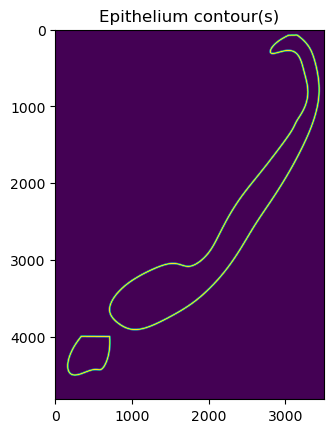

In [68]:
normals,smooth=gaussian_normals(contours)
contour_viz(smooth, "Epithelium contour(s)")